In [4]:
from datetime import datetime, timedelta
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd


IMSI = 'imsi'
MCC ='mcc'
DATE = 'date'

ENTRANCES = 'entrances'


date_fmt = '%Y-%m-%d'

DATA_FILEPATH = '/home/data_commons/andorra_data_2020/'

In [6]:
def get_homes_filepath(year, month):
    return '{}homes/{}_{}_homes.csv'.format(DATA_FILEPATH, year, month)

def get_stays_filepath(day, month, year):
    return '{}stays/{}_{}/stays_{}_{}_{}.csv'.format(DATA_FILEPATH, year, month, year, month, day)

def daterange(start_datetime, end_datetime):
    for n in range(int((end_datetime - start_datetime).days) + 1):
        yield start_datetime + timedelta(n)
        

start_date_2020 = '2020-01-01'
end_date_2020 = '2020-10-31'

datetimes = [d for d in daterange(datetime.strptime(start_date_2020, date_fmt), 
                                   datetime.strptime(end_date_2020, date_fmt))]
# datetimes

In [7]:
ALL = 'All'
OTHER_MCC = 'other'
NON_ANDORRAN = 'Non-Andorran'
ANDORRAN_MCC = '213'

mcc_names_dict = {
    '213':'Andorran',
    '214':'Spanish',
    '208':'French',
    '234':'British',
    # otherwise nationality is 'other'
    OTHER_MCC: 'Other'
}
mccs = list(mcc_names_dict.keys())

# Days observed

ind_days_observed and ind_days_present are used to denote the indices of the days the person is observed or assumed to be present. Indices are used to simplify the computation by avoiding datetime operations.

In [8]:
def get_days_observed(datetimes):
    """
    returns a dict containing one entry for each imsi
    each person-object contains informtion about the user and when they were observed:
        'days': a set containing all the indices of the days they were present
        'months': a set containing all the months they were present
    """
    all_persons_summary = {}
    ind_missing_dates=[]
    for i_date, date in enumerate(datetimes):
        stays_filepath = get_stays_filepath(date.day, date.month, date.year)
        date_str =  date.strftime("%Y-%m-%d")
        if i_date % 10 == 0:
            print('%s/%s %s' %  (i_date, len(datetimes), date_str))
        if not pathlib.Path(stays_filepath).is_file():
            ind_missing_dates += [i_date]
            print('%s\nfile not found: %s' % (date_str, stays_filepath))
            continue
        users = pd.read_csv(stays_filepath)[[IMSI,MCC, 'parish']].dropna().set_index(IMSI)
        users = users[~users.index.duplicated(keep='first')]
        users[MCC] = users[MCC].astype(str)
        for imsi, row in users.iterrows():
            if imsi not in all_persons_summary:
                all_persons_summary[imsi]={'mcc': row['mcc'], 'months':set([date.month]),'ind_days_observed':set([i_date])}
            else:
                all_persons_summary[imsi]['months'].add(date.month)
                all_persons_summary[imsi]['ind_days_observed'].add(i_date)
    return all_persons_summary, ind_missing_dates

In [9]:
 all_persons_summary, ind_missing_dates= get_days_observed(datetimes)

0/305 2020-01-01
10/305 2020-01-11
20/305 2020-01-21
30/305 2020-01-31
40/305 2020-02-10
2020-02-14
file not found: /home/data_commons/andorra_data_2020/stays/2020_2/stays_2020_2_14.csv
2020-02-15
file not found: /home/data_commons/andorra_data_2020/stays/2020_2/stays_2020_2_15.csv
2020-02-16
file not found: /home/data_commons/andorra_data_2020/stays/2020_2/stays_2020_2_16.csv
2020-02-17
file not found: /home/data_commons/andorra_data_2020/stays/2020_2/stays_2020_2_17.csv
2020-02-18
file not found: /home/data_commons/andorra_data_2020/stays/2020_2/stays_2020_2_18.csv
2020-02-19
file not found: /home/data_commons/andorra_data_2020/stays/2020_2/stays_2020_2_19.csv
50/305 2020-02-20
2020-02-20
file not found: /home/data_commons/andorra_data_2020/stays/2020_2/stays_2020_2_20.csv
2020-02-21
file not found: /home/data_commons/andorra_data_2020/stays/2020_2/stays_2020_2_21.csv
2020-02-22
file not found: /home/data_commons/andorra_data_2020/stays/2020_2/stays_2020_2_22.csv
2020-02-23
file not 

Generate a csv file of observed/unobserved by day for every individual (for plotting in TraMineR)

In [10]:
# observed_df=pd.DataFrame(index=range(len(all_persons_summary)), columns=range(len(datetimes)))
# observed_df.loc[:]=0
# for i, imsi in enumerate(all_persons_summary):
#     if i%10000==0:
#         print(i)
#     l_days_present=list(all_persons_summary[imsi]['ind_days_observed'])
#     observed_df.iloc[i][l_days_present]=1

# Infer days present, entrances and departures

Infer which days each user was present based on the days they were observed.<br>
Assume that small gaps in observations are days when the person was still present but their device was not observed.<br>
For larger gaps in observation, assume the person left <br>
<br>
eg. assuming a max window size of 3: if someone is observed on days 1,2,3,6,7,8,15,16.. <br>
we assume they were present on days 1,2,3,4,5,6,7,8,15,16 <br>
we also count a departure on day 9 and an entrance on day 15 <br>

When calculating the number of days the device is missing, don't count days which are entirely missing from the data.<br>
eg. for the same example above, if days 9,10,11,12 are missing from the data, then the device is assumed to be present during the entire period (because only days 13 and 14 are counted as missing for this user.

In [37]:
def infer_days_present(ind_days_observed, window, ind_missing_dates=[]):
    ind_days_observed=sorted(list(ind_days_observed))
    ind_days_present=set()
    entrances=[]
    departures=[]
    
    # TODO: simplify 3 blocks below into one block by setting ind_days_present= [-1]+[ind_days_present] + [len(datetimes)+1]
    
    # deal with period between start of study period and first observed day for this device
    missing_from_start=sum([1 for d in range(ind_days_observed[0]) if d not in ind_missing_dates])
    if missing_from_start<=window:
        for j in range(ind_days_observed[0]):
            ind_days_present.add(j)
    else:
        entrances.append(ind_days_observed[0])
        
    # deal with period between the first and last observed day
    for i in range(len(ind_days_observed)-1):
        ind_days_present.add(ind_days_observed[i])
        n_missing_days=sum([1 for d in range(ind_days_observed[i], ind_days_observed[i+1]) if d not in ind_missing_dates])
        if n_missing_days<=window:
            for j in range(ind_days_observed[i], ind_days_observed[i+1]):
                ind_days_present.add(j) 
        else:
            departures.append(ind_days_observed[i])
            entrances.append(ind_days_observed[i+1])
            
    # deal with period between last observed day and end of study period
    ind_days_present.add(ind_days_observed[-1])
    missing_from_end=sum([1 for d in range(ind_days_observed[-1], len(datetimes)) if d not in ind_missing_dates])
    if missing_from_end<=window:
        for j in range(ind_days_observed[-1], len(datetimes)):
            ind_days_present.add(j)
    else:
        departures.append(ind_days_observed[-1])
       
    return ind_days_present, departures, entrances

In [12]:
infer_days_present([1,2,3,6,7,8,15,16], window=3)

({0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16}, [8, 16], [15])

In [13]:
infer_days_present([1,2,3,6,7,8,15,16], window=3, ind_missing_dates=[9,10,11,12])

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}, [16], [])

In [14]:
infer_days_present([7,8,15,16,1,2,3,6], window=3)

({0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16}, [8, 16], [15])

In [15]:
infer_days_present([7, 8, 9, 15, 17, 19, 24, 25, 26], window=3)

({7, 8, 9, 15, 16, 17, 18, 19, 24, 25, 26}, [9, 19, 26], [7, 15, 24])

In [16]:
window=13

#### Apply to all persons to compute days_present for each person and the overall entrances and departures

##### presence_df
- 1 row per imsi
- 1 column per date
- 0 indicates person was absent, 1 indicates present but no stays, 0s indicate present and has at least 1 stay

In [38]:
mcc_names=[mcc_names_dict[code]  for code in mcc_names_dict]
columns=['entrance_{}'.format(name) for name in mcc_names]+['departures_{}'.format(name) for name in mcc_names]

entrance_departure=pd.DataFrame(index=datetimes, columns=columns)
entrance_departure.loc[:,:]=0

presence_df=pd.DataFrame(index=[imsi for imsi in all_persons_summary], columns=range(len(datetimes)))
presence_df.loc[:,:]=0

for ind_imsi, imsi in enumerate(all_persons_summary):
    if ind_imsi%10000==0:
        print(ind_imsi)
    ind_days_observed=all_persons_summary[imsi]['ind_days_observed']
    mcc=all_persons_summary[imsi]['mcc']
    if mcc in mcc_names_dict:
        mcc_name=mcc_names_dict[mcc]
    else:
        mcc_name='Other'
    ind_days_present, departures, entrances= infer_days_present(ind_days_observed, window, ind_missing_dates)
    all_persons_summary[imsi]['entrances']=entrances
    all_persons_summary[imsi]['departures']=departures
    all_persons_summary[imsi]['ind_days_present']=ind_days_present
    
    # update the the total entrances and exits
    for ind_day in entrances:
        entrance_departure.loc[datetimes[ind_day], 'entrance_{}'.format(mcc_name)]+=1
    for ind_day in departures:
        entrance_departure.loc[datetimes[ind_day], 'departures_{}'.format(mcc_name)]+=1
        
    # update the overall dataframe of presence/absence
    presence_df.iloc[ind_imsi][ind_days_present]=1
    presence_df.iloc[ind_imsi][ind_days_observed]=2

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000


In [39]:
presence_df=presence_df.rename(columns={i:datetimes[i] for i in range(len(datetimes))}) 
presence_df.head()

,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00,2020-01-05 00:00:00,2020-01-06 00:00:00,2020-01-07 00:00:00,2020-01-08 00:00:00,2020-01-09 00:00:00,2020-01-10 00:00:00,...,2020-10-22 00:00:00,2020-10-23 00:00:00,2020-10-24 00:00:00,2020-10-25 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00,2020-10-28 00:00:00,2020-10-29 00:00:00,2020-10-30 00:00:00,2020-10-31 00:00:00
6883f23609eeb41bd335703b55c70b066c00a892864f2bd8832d249c4660d64b,2,2,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aa27e3c75cb92fd72d62b402de7822c60ba65dc7859556c88066ab32180ac7bb,2,1,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
08c82f482b02877bc327502d3803cbae365888e2b55e01f76ead3abfecf5b50e,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21fface346504a2da8244d7d1ec1f68609d163f8b2d2f42d74fe6bccdbe26e43,2,2,1,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cfd761190f99f69586c8278519a94ff8ece5f3812166e2f1cdbc01c46084b80d,2,2,2,2,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Plot entrances and departures

In [40]:
import matplotlib as mpl
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker

cmap = plt.get_cmap("tab10")

In [41]:
mcc_name_colors={'Andorran':'yellow', 'Spanish':'orange', 'French':'blue', 'British':'red', 'Other':'green'}

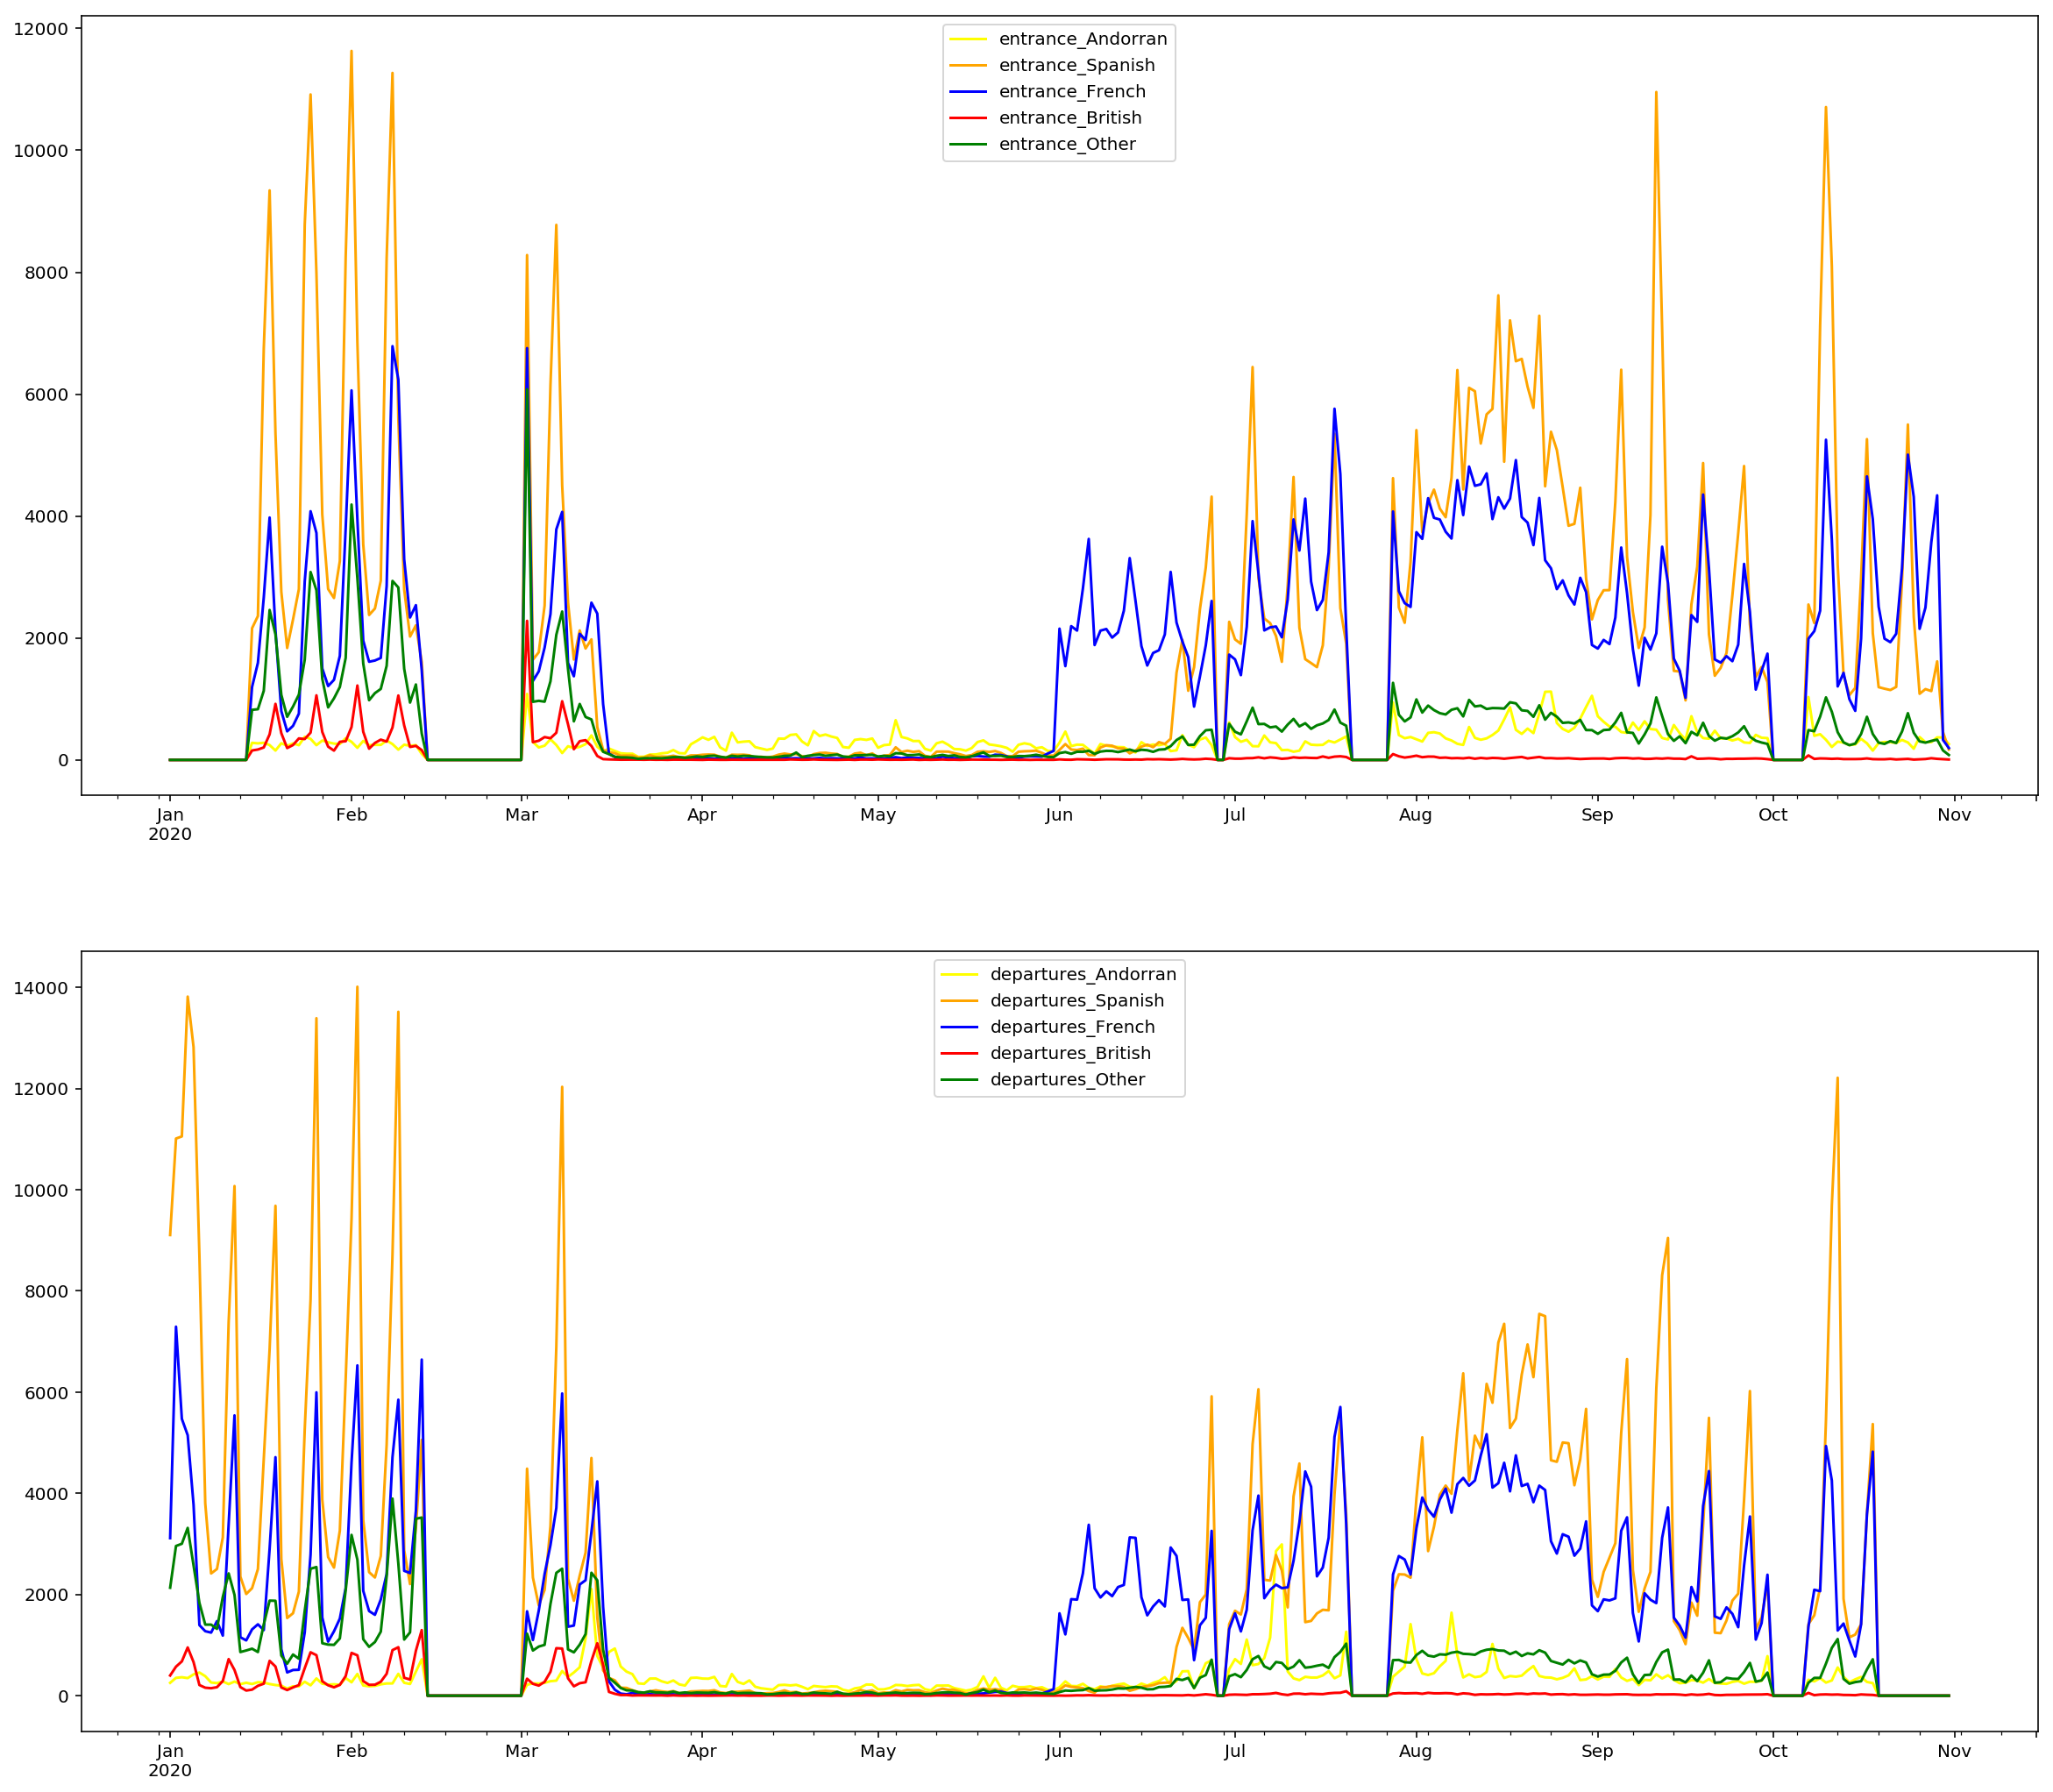

In [42]:
fig, axes = plt.subplots(2, figsize=(20, 18))
for mn in mcc_names:
    entrance_departure['entrance_{}'.format(mn)].plot(legend=True, ax=axes[0], color=mcc_name_colors[mn])
    entrance_departure['departures_{}'.format(mn)].plot(legend=True, ax=axes[1], color=mcc_name_colors[mn])



In [22]:
entrance_departure.to_csv(DATA_FILEPATH+'days_present/entrance_departure.csv')

# Infer residency status- In Progress

In [23]:
def len_longest_stay(entrances, departures):
    entrances=[-1] + entrances
    departures=departures + [len(datetimes)]
    max_stay=0
    for ent in entrances:
        next_dep=next((dep for dep in departures if (dep>ent)))
        len_stay=next_dep-ent
        if len_stay>max_stay:
            max_stay=len_stay
    return max_stay

In [24]:
ind_date_start_lockdown=next((index for index, date in enumerate(datetimes) if (
            (date.month == 3) and (date.day == 14))))
# many people seem to stay for first half of year, then leave around July/10
ind_date_july_10=next((index for index, date in enumerate(datetimes) if (
            (date.month == 7) and (date.day == 10))))

# Histogram length of longest stay

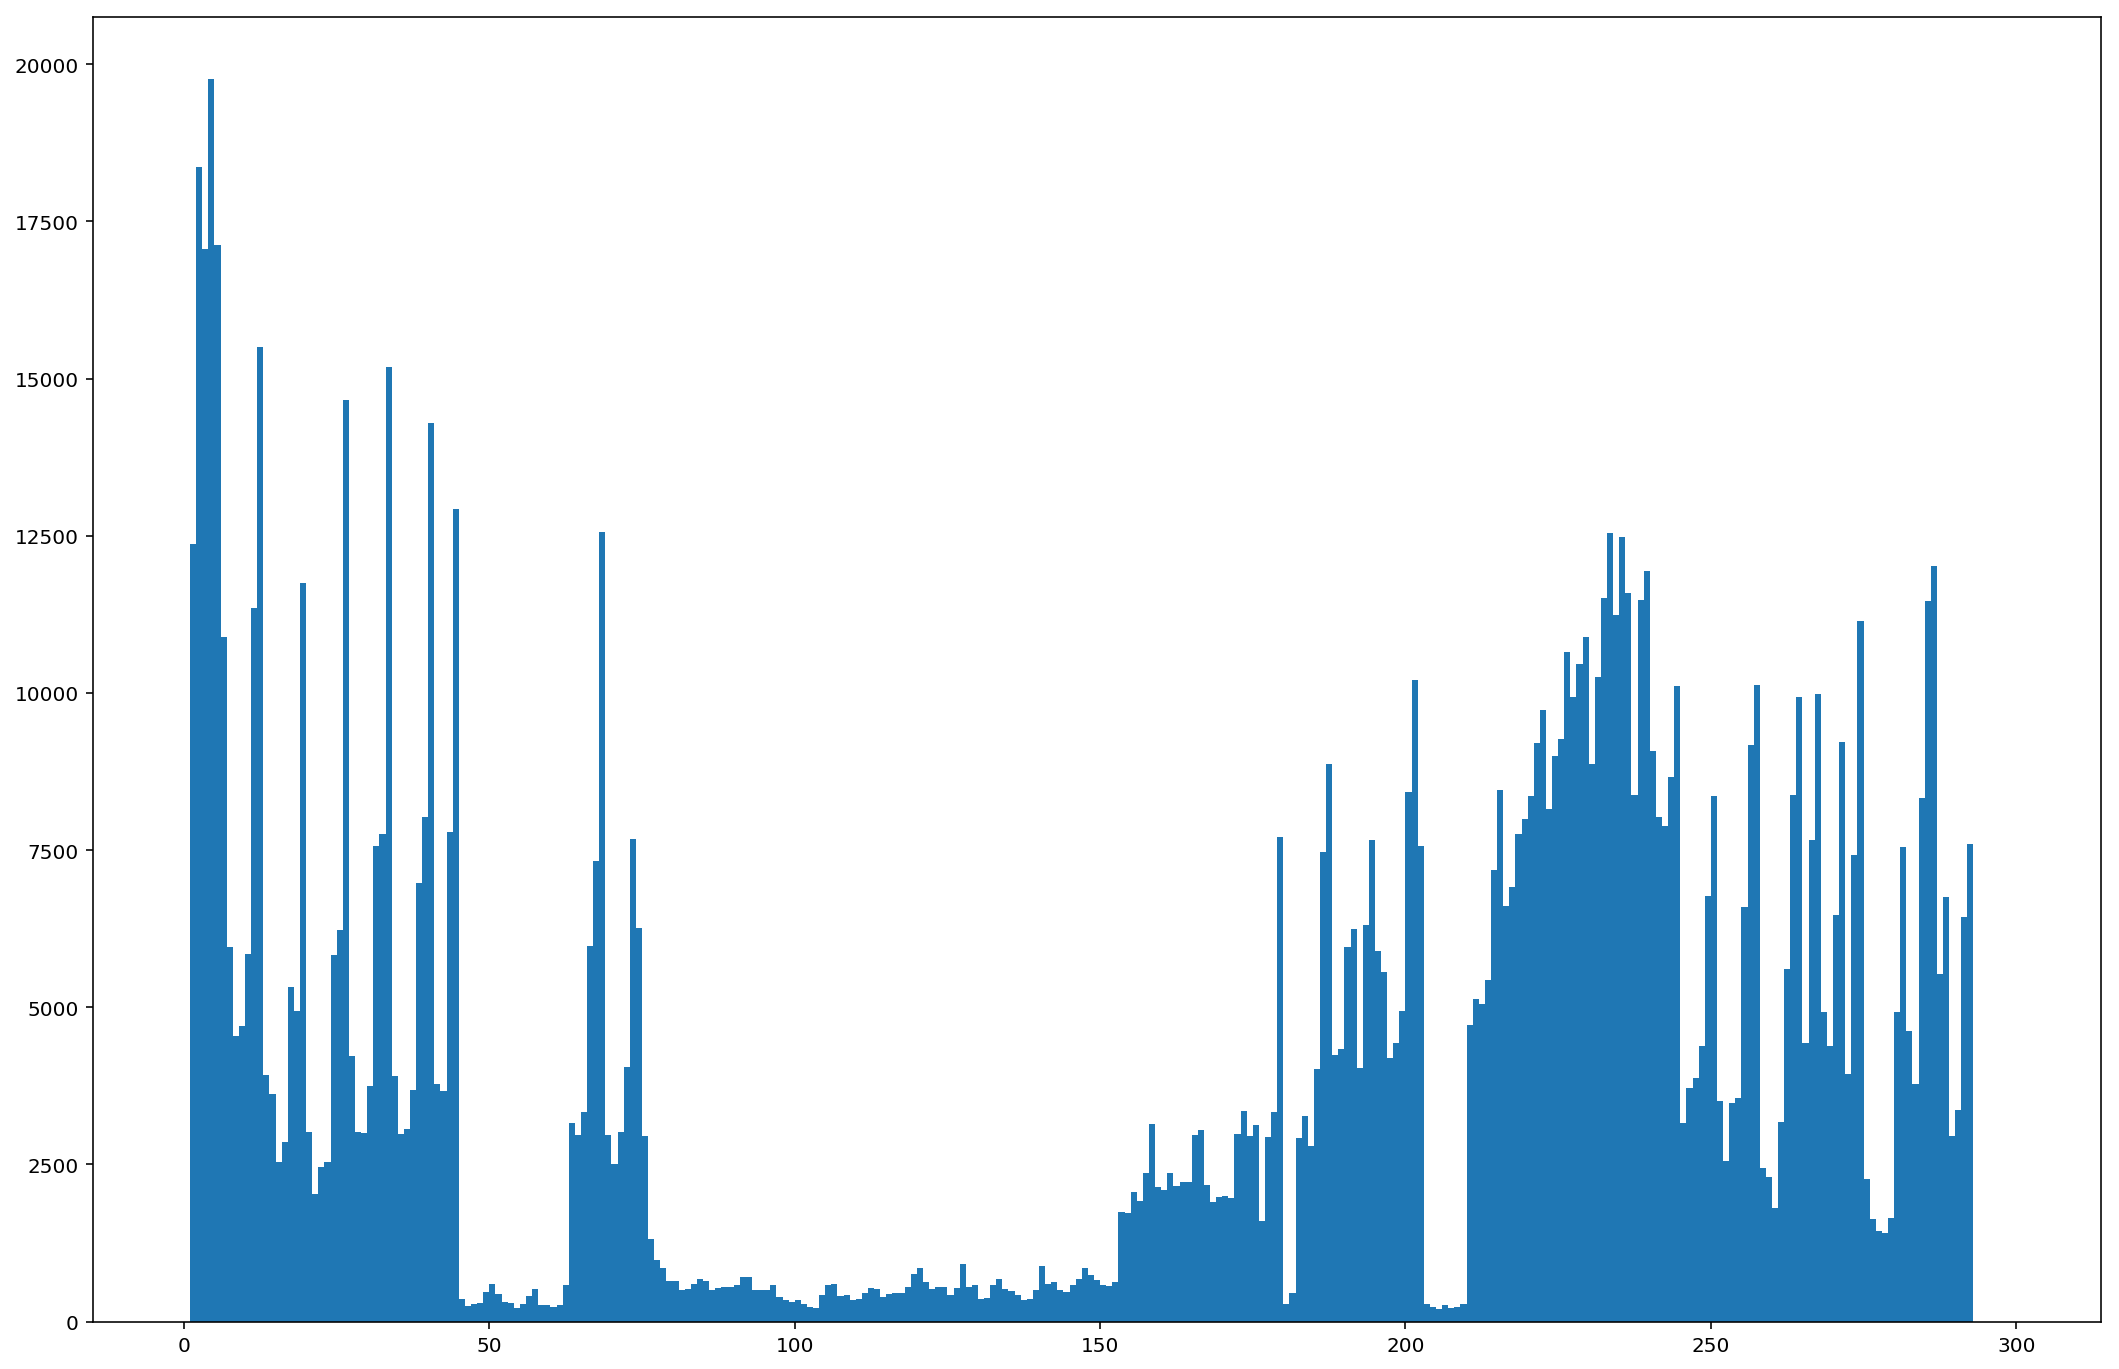

In [25]:
plt.figure(figsize=(18,12))
_=plt.hist([len_longest_stay(all_persons_summary[imsi]['entrances'],
                           all_persons_summary[imsi]['departures']) for imsi in all_persons_summary],
        bins=range(300))

# Histogram total days present

In [3]:
n_days_present_by_imsi=presence_df.applymap(lambda x: x>0).sum(axis=1)
n_days_observed_by_imsi=presence_df.applymap(lambda x: x>1).sum(axis=1)
n_days_present_by_imsi.head()

imsi
6883f23609eeb41bd335703b55c70b066c00a892864f2bd8832d249c4660d64b     4
08c82f482b02877bc327502d3803cbae365888e2b55e01f76ead3abfecf5b50e    10
21fface346504a2da8244d7d1ec1f68609d163f8b2d2f42d74fe6bccdbe26e43     5
cfd761190f99f69586c8278519a94ff8ece5f3812166e2f1cdbc01c46084b80d     6
6fc666df4c75a9281fd96d3cc5926055ca05a56760d18ffddeed4405ca361d2d     6
dtype: int64

In [4]:
# plt.figure(figsize=(18,12))
# _=plt.hist([len(all_persons_summary[imsi]['ind_days_present']) for imsi in all_persons_summary],
#         bins=range(50))

### Days Observed Distribution

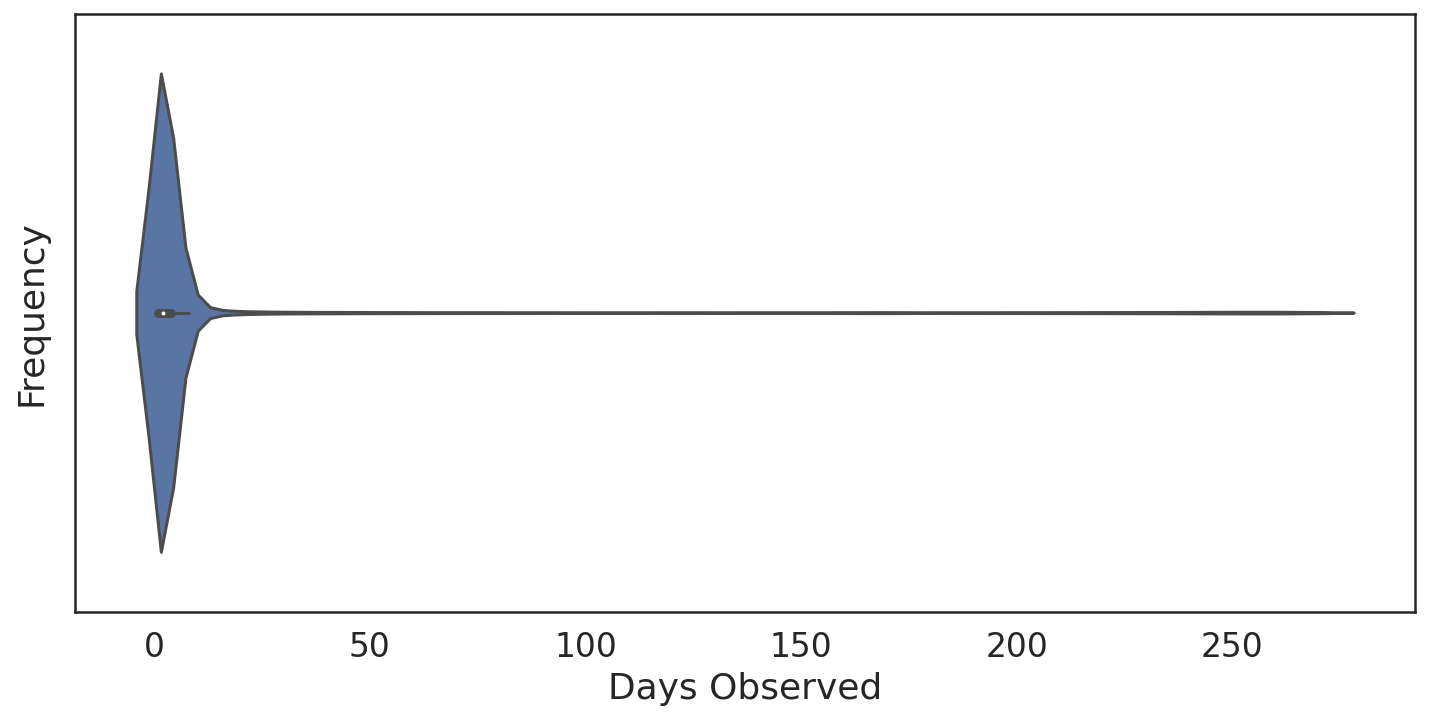

In [12]:
import seaborn as sns
sns.set(font_scale=1.5) 
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12, 5.5))
sns.set_theme(style="white")
v = sns.violinplot(x=n_days_observed_by_imsi.values, ax=ax)
ax.set(ylabel='Frequency', xlabel='Days Observed')
fig.savefig("/home/workspace/rdoorley/CSL_Andorra_COVID/outputs/days_observed_violin.png", dpi=300)

### Days Present Distribution

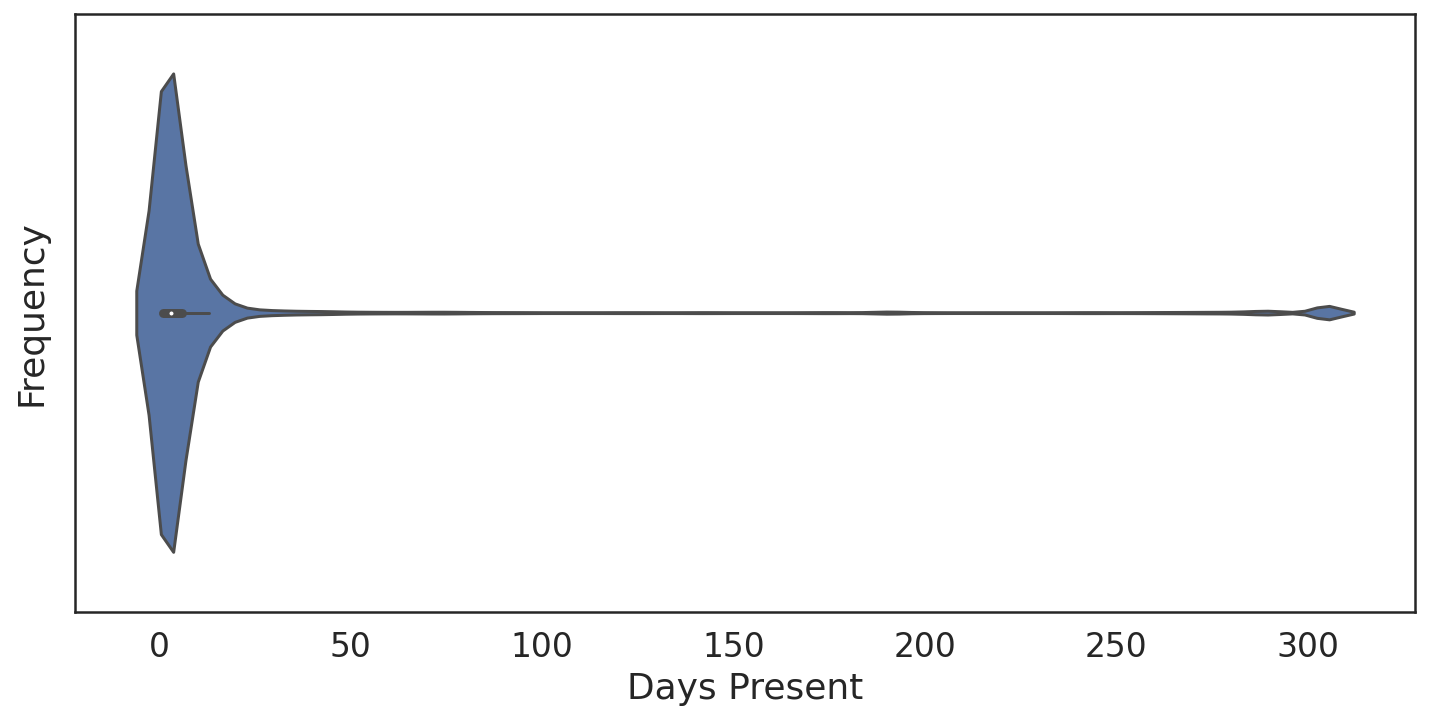

In [11]:
fig, ax = plt.subplots(figsize=(12, 5.5))
sns.set_theme(style="white")
v = sns.violinplot(x=n_days_present_by_imsi.values, ax=ax)
ax.set(ylabel='Frequency', xlabel='Days Present')
fig.savefig("/home/workspace/rdoorley/CSL_Andorra_COVID/outputs/days_present_violin.png", dpi=300)

In [ ]:
# import seaborn as sns
# sns.set(font_scale=1.5) 
# sns.set_style("white")
# fig, ax = plt.subplots(figsize=(12, 5.5))
# sns.set_theme(style="white")
# v = sns.boxplot(x=n_days_present_by_imsi.values, ax=ax)
# ax.set(ylabel='Frequency', xlabel='Days Present')
# fig.savefig("/home/workspace/rdoorley/CSL_Andorra_COVID/outputs/days_present_box.png")

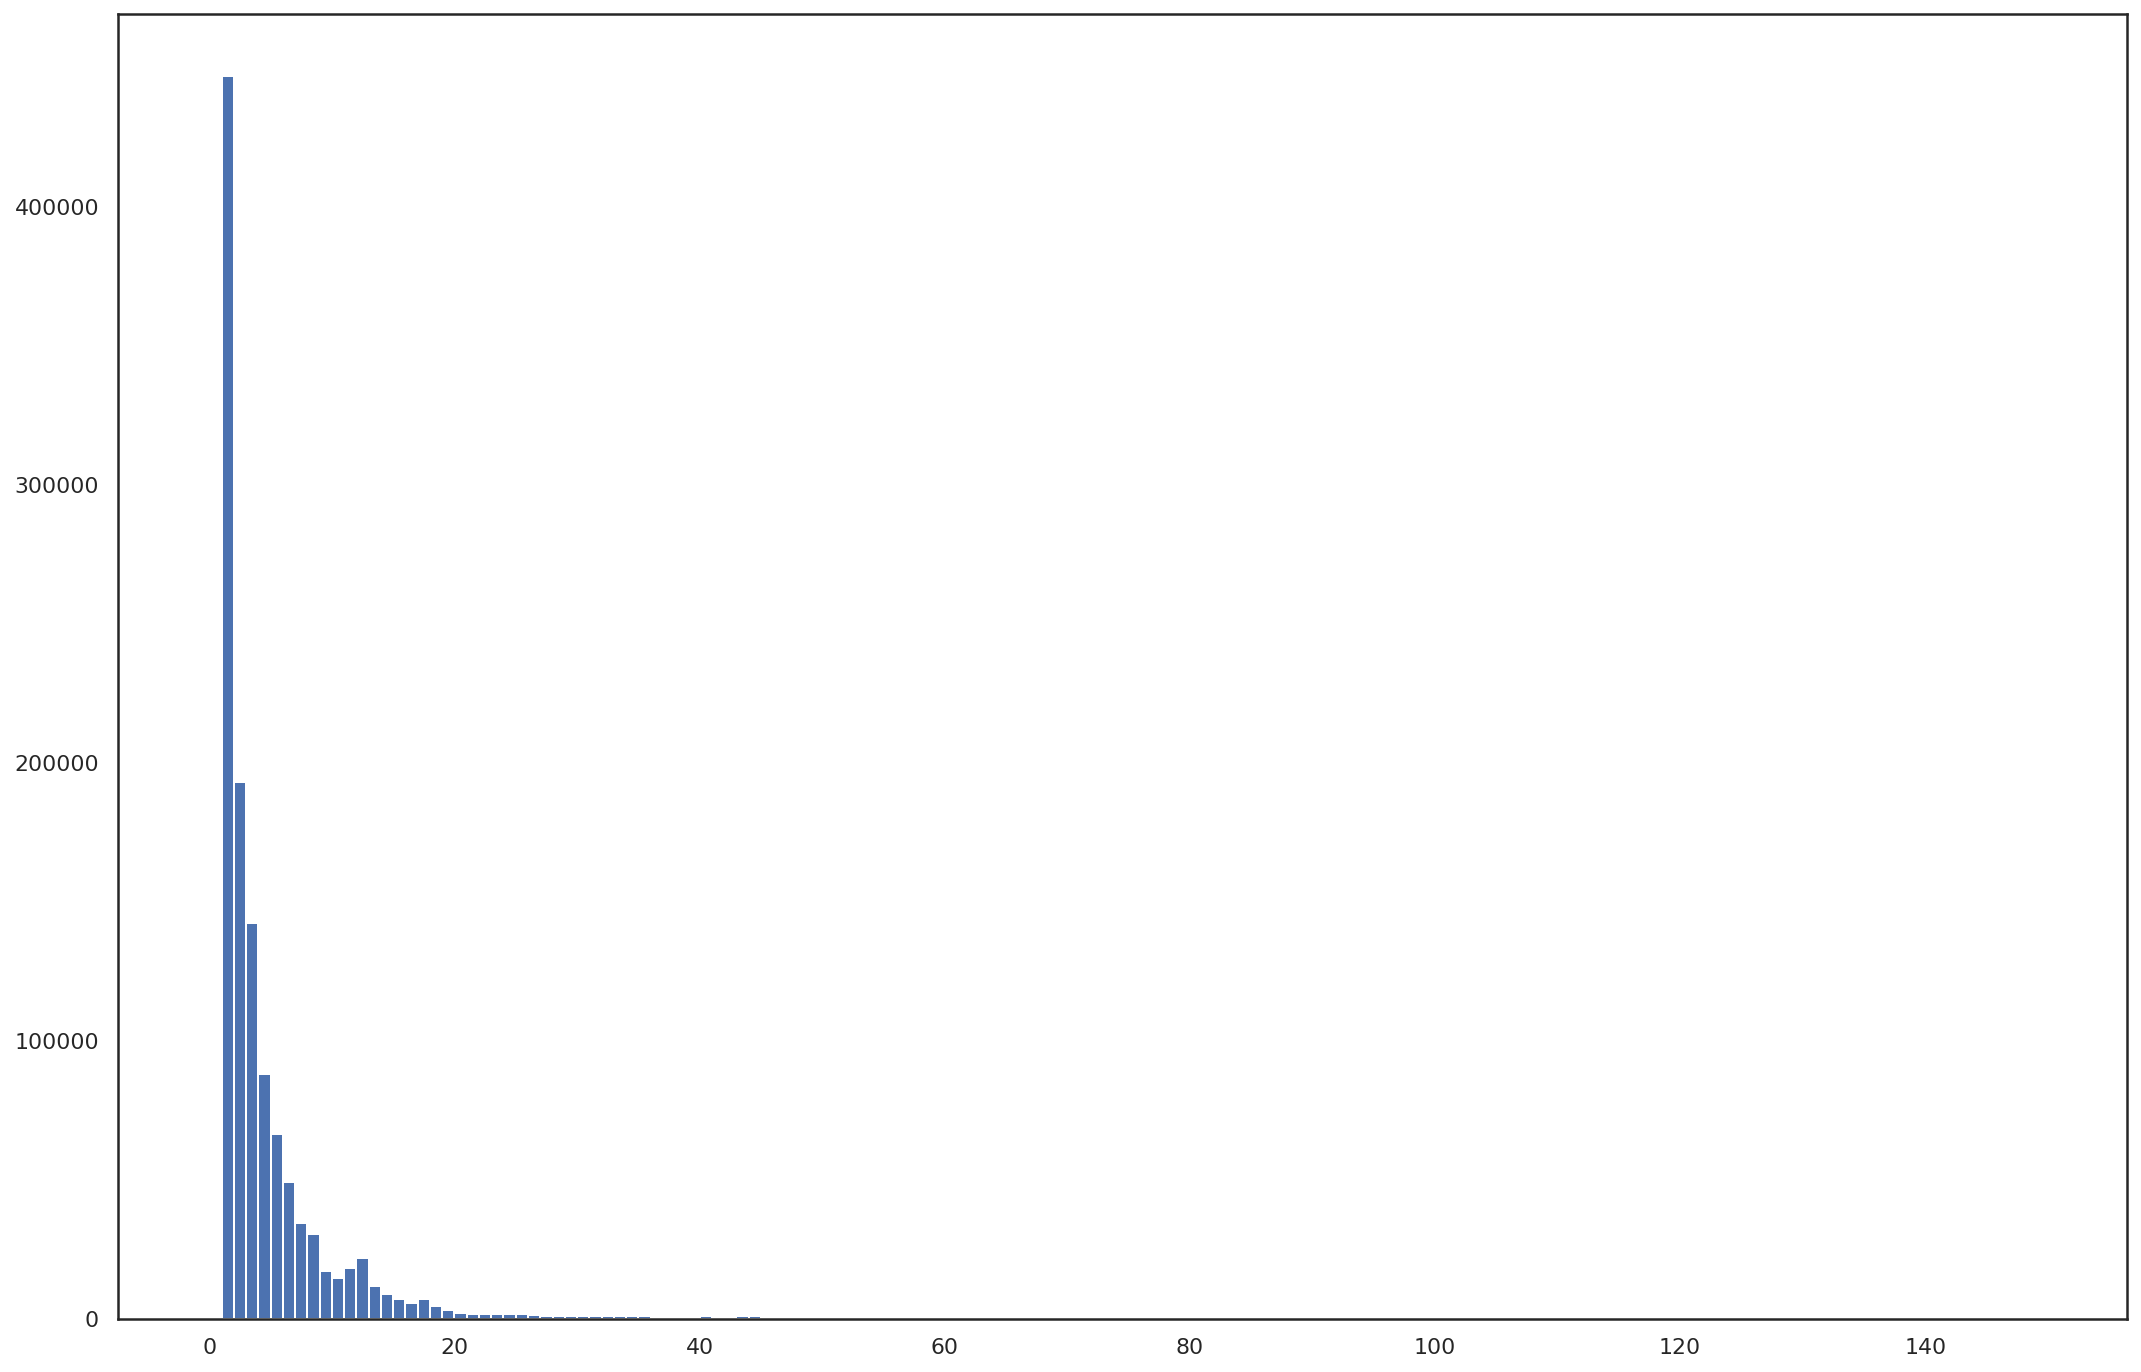

In [7]:
plt.figure(figsize=(18,12))
_=plt.hist(n_days_present_by_imsi.values,
        bins=range(150))

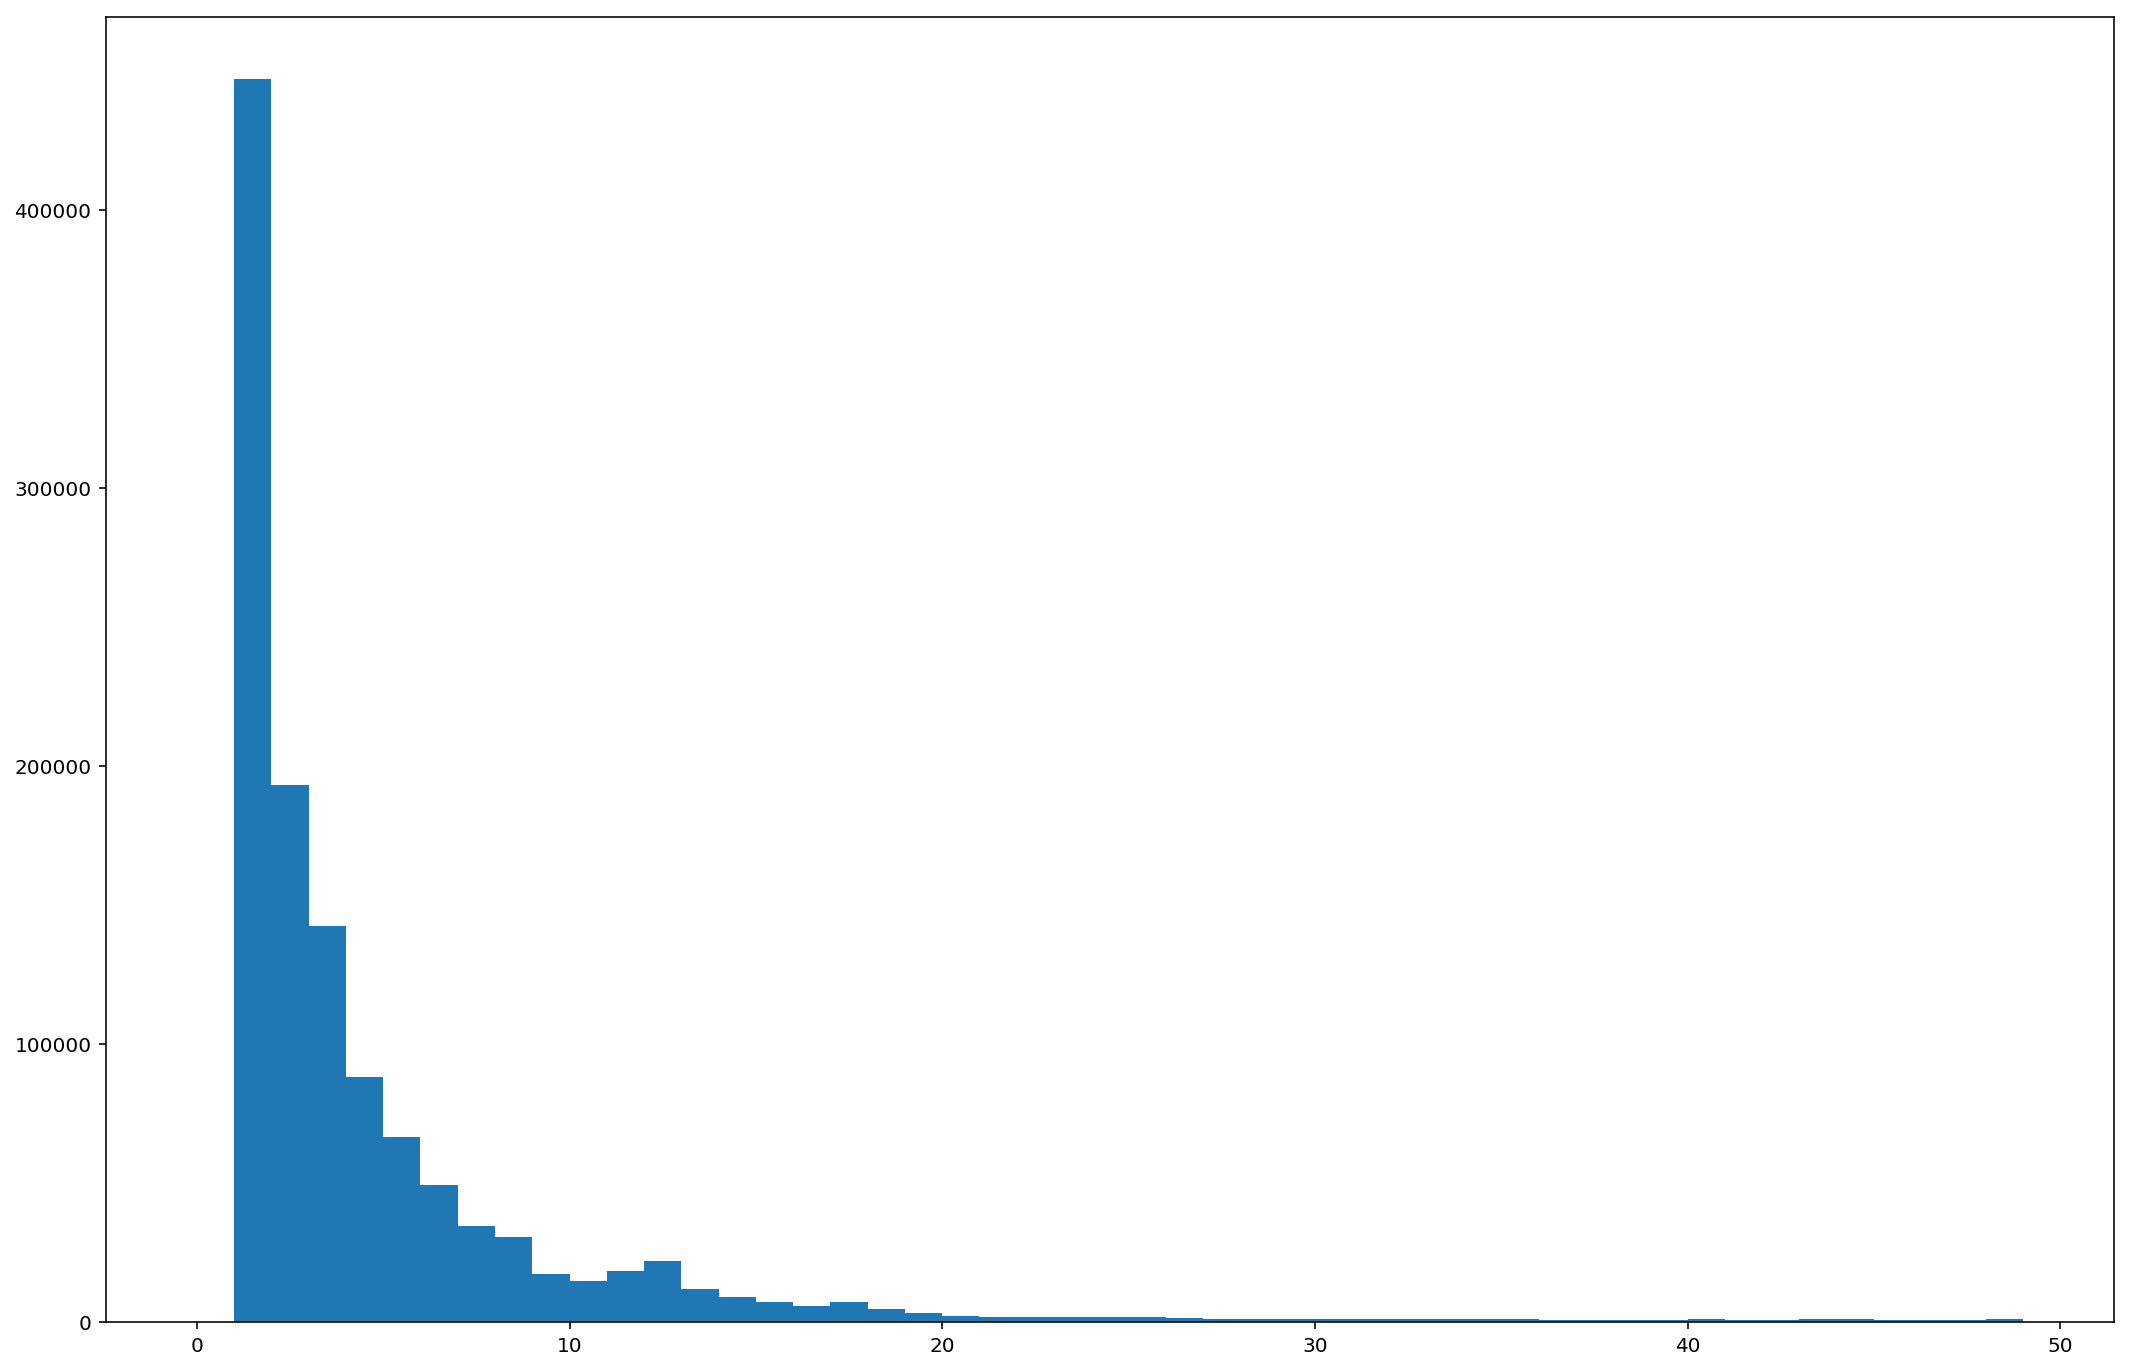

In [32]:
plt.figure(figsize=(18,12))
_=plt.hist(n_days_present_by_imsi.values,
        bins=range(50))

#### Tourists
are observed on fewer than 50 days of the whole datset

#### Reidents (Ordinary or Temp)
everyone else

In [56]:
# for imsi in all_persons_summary:
#     if n_days_observed_by_imsi.loc[imsi]>=50:
#         all_persons_summary[imsi]['status']='resident'
#     else:
#         all_persons_summary[imsi]['status']='tourist'

In [34]:
# for imsi in all_persons_summary:
#     if len(all_persons_summary[imsi]['ind_days_observed'])>=50:
#         # long term stay: either a permanent resident or temp worker
#         stays_after_jul_10=sum([1 for d in all_persons_summary[imsi]['ind_days_observed'] if d>=ind_date_july_10])
#         if stays_after_jul_10>0:
#             all_persons_summary[imsi]['status']='resident'
#         else:
#             all_persons_summary[imsi]['status']='temp'
#     else:
#         all_persons_summary[imsi]['status']='tourist'

In [50]:
for imsi in all_persons_summary:
    if len(all_persons_summary[imsi]['ind_days_observed'])>=50:
        # long term stay: either a permanent resident or temp worker
        all_persons_summary[imsi]['status']='resident'
    else:
        all_persons_summary[imsi]['status']='tourist'

Ensure the results makes sense by checking the mcc of each category

In [57]:
ct_nation_status=pd.crosstab(pd.Series([all_persons_summary[p]['status'] for p in all_persons_summary]),
                         pd.Series([all_persons_summary[p]['mcc'] for p in all_persons_summary]),
                         normalize=0)

In [275]:
ct_nation_status

col_0,1,202,204,206,208,213,214,216,218,219,...,716,722,724,730,732,734,740,744,748,901
row_0,,,,,,,,,,,,,,,,,,,,,
resident,0.000000e+00,0.00000,0.028972,0.000631,0.039286,0.864101,0.042472,0.000015,0.000000,0.000000,...,0.000015,0.000816,0.000062,0.000123,0.000062,0.00000,0.000000,0.000046,0.000015,0.001539
temp,0.000000e+00,0.00093,0.015222,0.000465,0.020683,0.776900,0.108994,0.000000,0.000000,0.000116,...,0.000349,0.028701,0.000581,0.001511,0.000697,0.00000,0.000000,0.000232,0.000000,0.000581
tourist,7.876447e-07,0.00015,0.034645,0.007436,0.374786,0.014800,0.471286,0.000193,0.000009,0.000054,...,0.000041,0.001396,0.000858,0.000116,0.000206,0.00001,0.000009,0.000045,0.000061,0.002622


# Compute number of people present on each day

In [59]:
people_present_status={status: [0  for date in range(len(datetimes))] for status in ['resident', 'temp', 'tourist']}
people_present_nation={nation: [0  for date in range(len(datetimes))] for nation in ['Andorran', 'Spanish','French', 'British' ,'Other']}
for imsi in all_persons_summary:
    for ind_day in all_persons_summary[imsi]['ind_days_present']:
        people_present_status[all_persons_summary[imsi]['status']][ind_day]+=1
        if all_persons_summary[imsi]['mcc'] in mcc_names_dict:
            mn=mcc_names_dict[all_persons_summary[imsi]['mcc']]
        else:
            mn='Other'
        people_present_nation[mn][ind_day]+=1

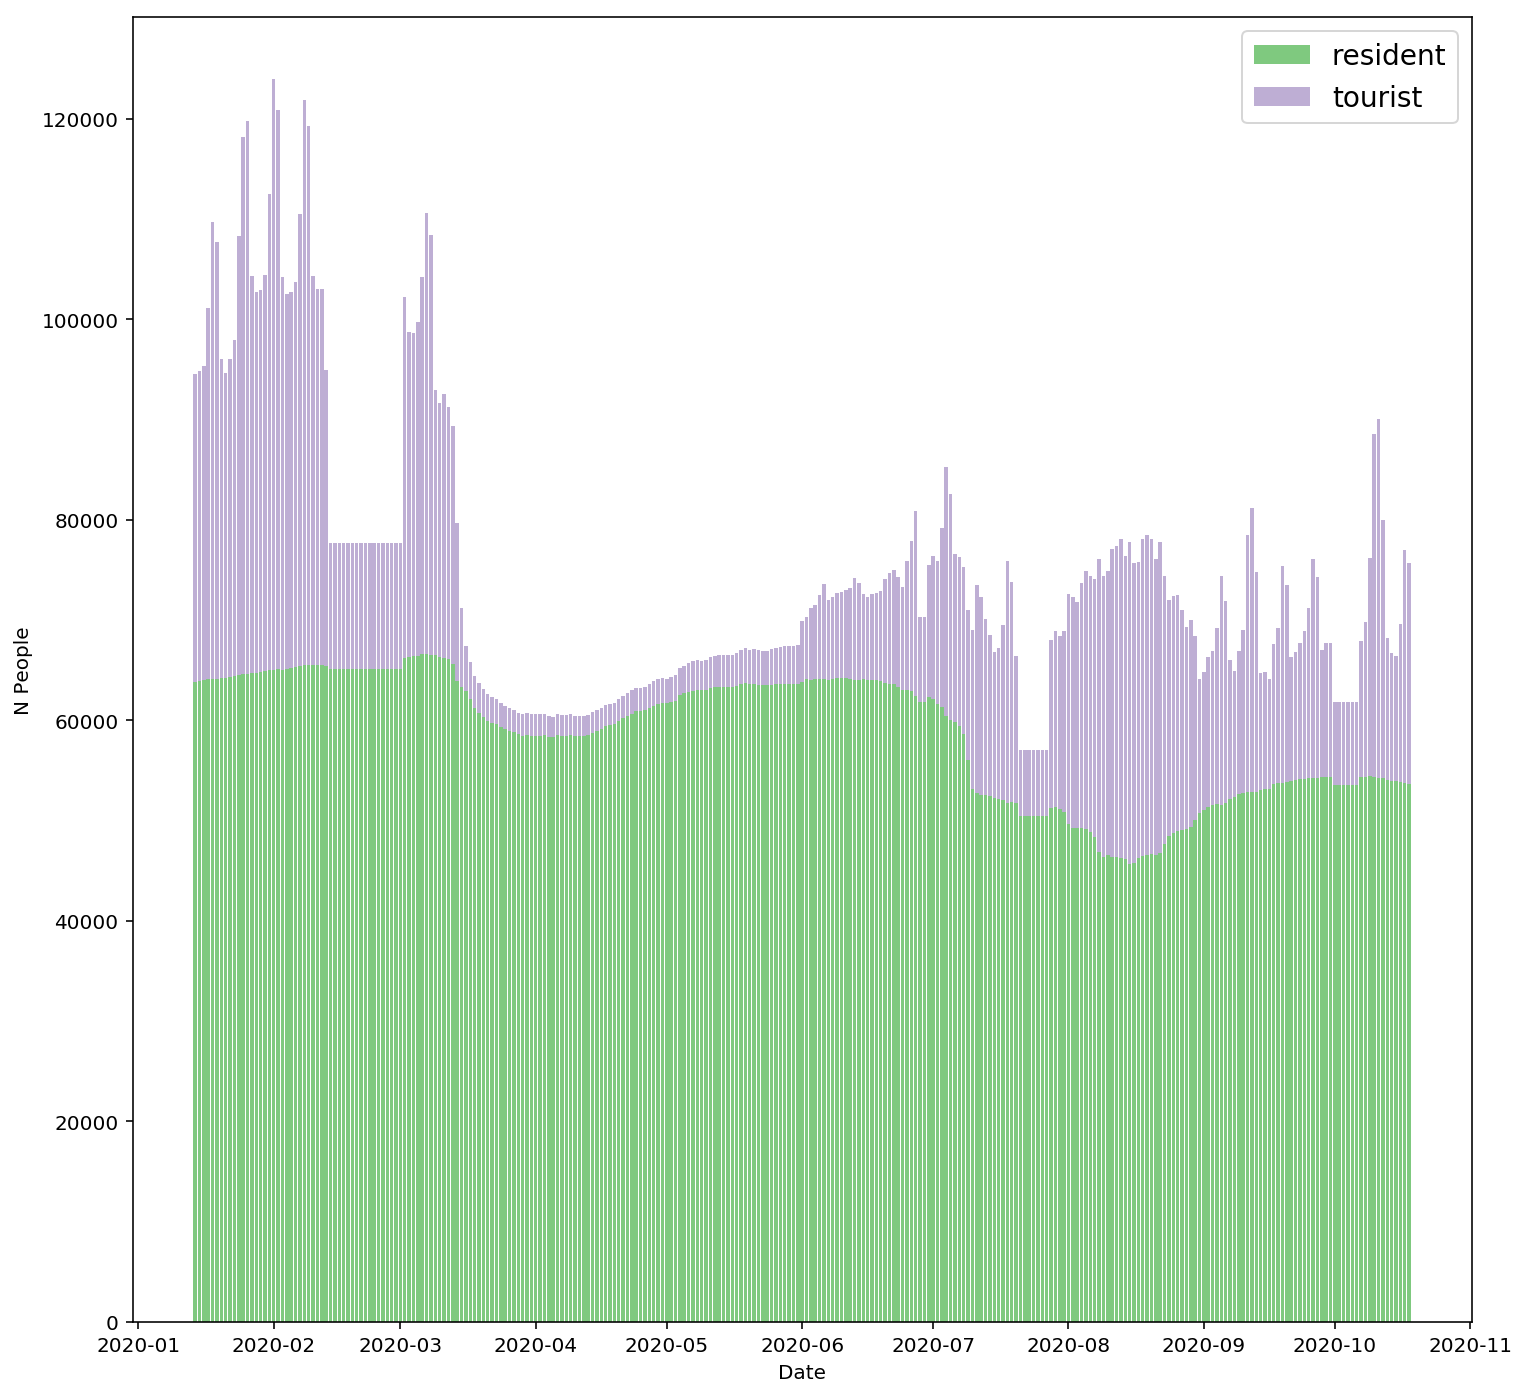

In [61]:
plt.figure(figsize=(12,12))

# don't plot the start and end of the series are they are biased
burn_in=window
burn_out=window

series_len=len(people_present_status['resident'][burn_in:-burn_out])
totals=np.array([0 for i in range(series_len)])

status_colors={'resident': '#7fc97f', 
               'tourist': '#beaed4' 
              }

bars={}
for status in status_colors:
    series=people_present_status[status][burn_in:-burn_out]
    bars[status]=plt.bar(datetimes[burn_in:-burn_out], series, 
             bottom=totals,color=status_colors[status], align='center')
    totals+=np.array(series)

plt.ylabel('N People')
plt.xlabel('Date')

leg=plt.legend([bars[status] for status in status_colors], 
             [status for status in status_colors], fontsize=15, prop={'size': 14})
# for text in leg.get_texts():
#     plt.setp(text, color = 'k')

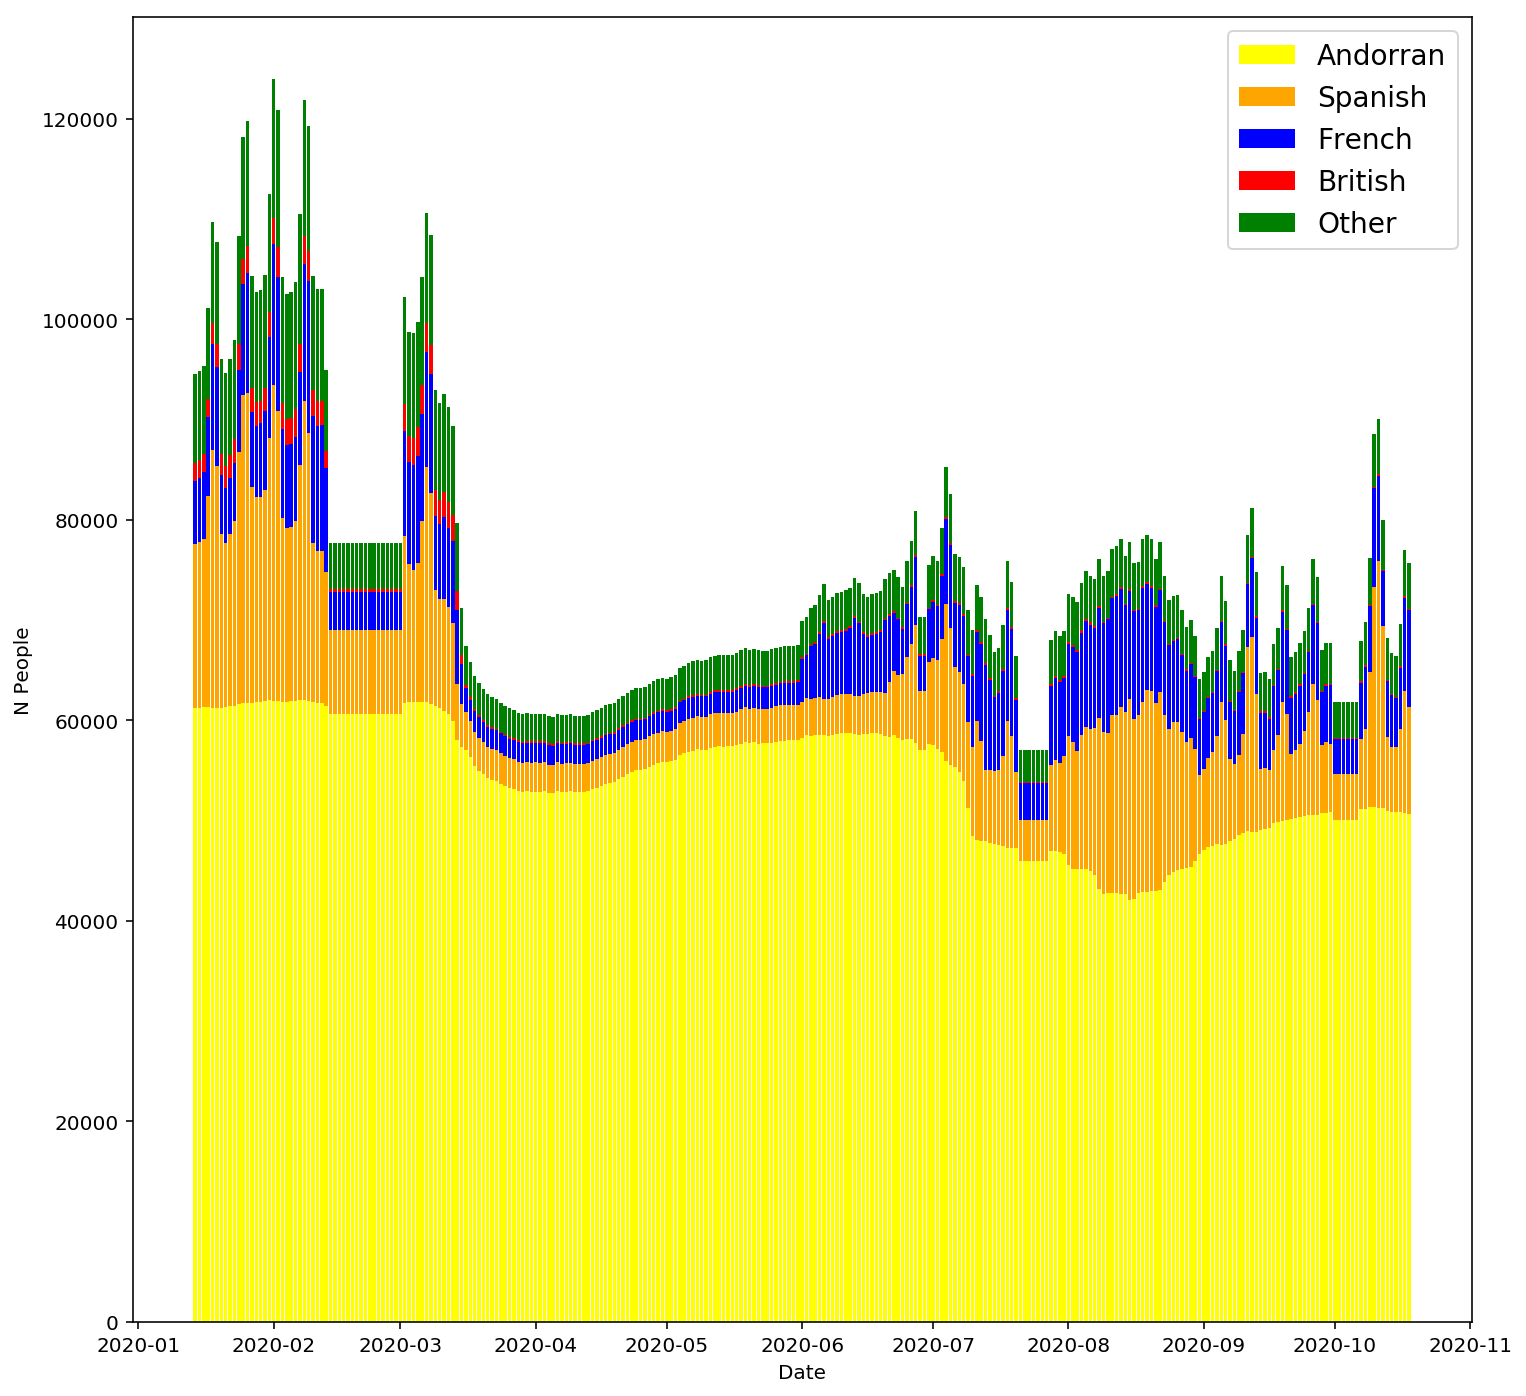

In [62]:
plt.figure(figsize=(12,12))

# don't plot the start and end of the series are they are biased
burn_in=window
burn_out=window

series_len=len(people_present_nation['Andorran'][burn_in:-burn_out])
totals=np.array([0 for i in range(series_len)])

bars={}
for mn in mcc_name_colors:
    series=people_present_nation[mn][burn_in:-burn_out]
    bars[mn]=plt.bar(datetimes[burn_in:-burn_out], series, 
             bottom=totals,color=mcc_name_colors[mn], align='center')
    totals+=np.array(series)

plt.ylabel('N People')
plt.xlabel('Date')

leg=plt.legend([bars[mn] for mn in mcc_name_colors], 
             [mn for mn in mcc_name_colors], fontsize=15, prop={'size': 14})
# for text in leg.get_texts():
#     plt.setp(text, color = 'k')

# Save presence dataframe: one csv for tourists and one for others

In [63]:
ind_tourist, ind_other=[], []

for ind, imsi in enumerate(all_persons_summary):
    if all_persons_summary[imsi]['status']=='tourist':
        ind_tourist.append(ind)
    else:
        ind_other.append(ind)

In [65]:
presence_df.iloc[ind_tourist].to_csv(DATA_FILEPATH+'days_present/presence_tourists.csv')
presence_df.iloc[ind_other].to_csv(DATA_FILEPATH+'days_present/presence_others.csv')

In [2]:
# presence_df_tourists=pd.read_csv(DATA_FILEPATH+'days_present/presence_tourists.csv')
# presence_df_non_tourists=pd.read_csv(DATA_FILEPATH+'days_present/presence_others.csv')
# presence_df=presence_df_tourists.append(presence_df_non_tourists)
# presence_df=presence_df.rename(columns={'Unnamed: 0':'imsi'}).set_index('imsi')